# Análise dos números da Mega Sena

<strike>Projeto realizado com os dados históricos dos sorteios realizados até 10/08/2019: <u>Concurso 2178</u> <br> </strike>

Projeto adaptado para trabalhar com as versões mais recentes do sorteio.

* <b>Parte 1:</b> Análise Exploratória dos Dados <br>
* <b>Parte 2:</b> Testes Estatísticos <br>
* <b>Parte 3:</b> Utilizando LSTM para prever um jogo vencedor

site: http://loterias.caixa.gov.br/wps/portal/loterias/landing/megasena/

## Análise Exploratória dos Dados

In [1]:
# Importação dos pacotes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from analysis.functions import download_raffle_file
from analysis.functions import transform_html_to_csv
from analysis.functions import pre_process_dataframe
from analysis.functions import get_data_dir
from analysis.functions import print_frequency_report

In [2]:
DOWNLOAD_PATH = 'http://www1.caixa.gov.br/loterias/_arquivos/loterias/D_megase.zip'
FILENAME = 'raffle.html'

SAVE_PATH = get_data_dir()

In [3]:
download_raffle_file(url=DOWNLOAD_PATH, path=SAVE_PATH, filename=FILENAME)
transform_html_to_csv(path=SAVE_PATH, filename=FILENAME)

In [4]:
mega_sena = pre_process_dataframe(filename=FILENAME, drop=['Cidade', 'UF'])

In [5]:
# Definindo nome das colunas
names = ['Data', '1_n', '2_n','3_n', '4_n', '5_n', '6_n', 'Arrec', 'Sena', 'Valor_Sena', 'Quina',
         'Valor_Quina', 'Quadra', 'Valor_Quadra', 'Acumulado', 'Valor_Acumulado', 'Estimativa', 'Mega_Virada']

In [6]:
# Alterando os nomes para facilitar a manipulação
mega_sena.columns = names

# Vizualizando as primeiras linhas
mega_sena.head() 

,Data,1_n,2_n,3_n,4_n,5_n,6_n,Arrec,Sena,Valor_Sena,Quina,Valor_Quina,Quadra,Valor_Quadra,Acumulado,Valor_Acumulado,Estimativa,Mega_Virada
Concurso,,,,,,,,,,,,,,,,,,
1,1996-11-03,41,5,4,52,30,33,0.0,0,0.00,17,39158.92,2016,330.21,SIM,1714650.23,0,0.0
2,1996-03-18,9,39,37,49,43,41,0.0,1,2307162.23,65,14424.02,4488,208.91,NÃO,0.00,0,0.0
3,1996-03-25,36,30,10,11,29,47,0.0,2,391192.51,62,10515.93,4261,153.01,NÃO,0.00,0,0.0
4,1996-01-04,6,59,42,27,1,5,0.0,0,0.00,39,15322.24,3311,180.48,SIM,717080.75,0,0.0
5,1996-08-04,1,19,46,6,16,2,0.0,0,0.00,98,5318.10,5399,96.53,SIM,1342488.85,0,0.0


In [7]:
# Verificando os tipos dos dados importados
mega_sena.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2302 entries, 1 to 2302
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Data             2302 non-null   datetime64[ns]
 1   1_n              2302 non-null   Int64         
 2   2_n              2302 non-null   Int64         
 3   3_n              2302 non-null   Int64         
 4   4_n              2302 non-null   Int64         
 5   5_n              2302 non-null   Int64         
 6   6_n              2302 non-null   Int64         
 7   Arrec            2302 non-null   float64       
 8   Sena             2302 non-null   Int64         
 9   Valor_Sena       2302 non-null   float64       
 10  Quina            2302 non-null   Int64         
 11  Valor_Quina      2302 non-null   float64       
 12  Quadra           2302 non-null   Int64         
 13  Valor_Quadra     2302 non-null   float64       
 14  Acumulado        2302 non-null   string 

In [8]:
# Realizando slice para plotagem das informações
sorteios_ano = mega_sena.groupby(mega_sena.Data.dt.year).count().iloc[:, 0]

ganhadores_ano = mega_sena.groupby(mega_sena.Data.dt.year).sum().loc[:, ['Sena']]

premios_ano = mega_sena.groupby(mega_sena.Data.dt.year).sum().loc[:, ['Valor_Sena']]

arrec_ano = mega_sena.groupby(mega_sena.Data.dt.year).sum().loc[:, ['Arrec']]

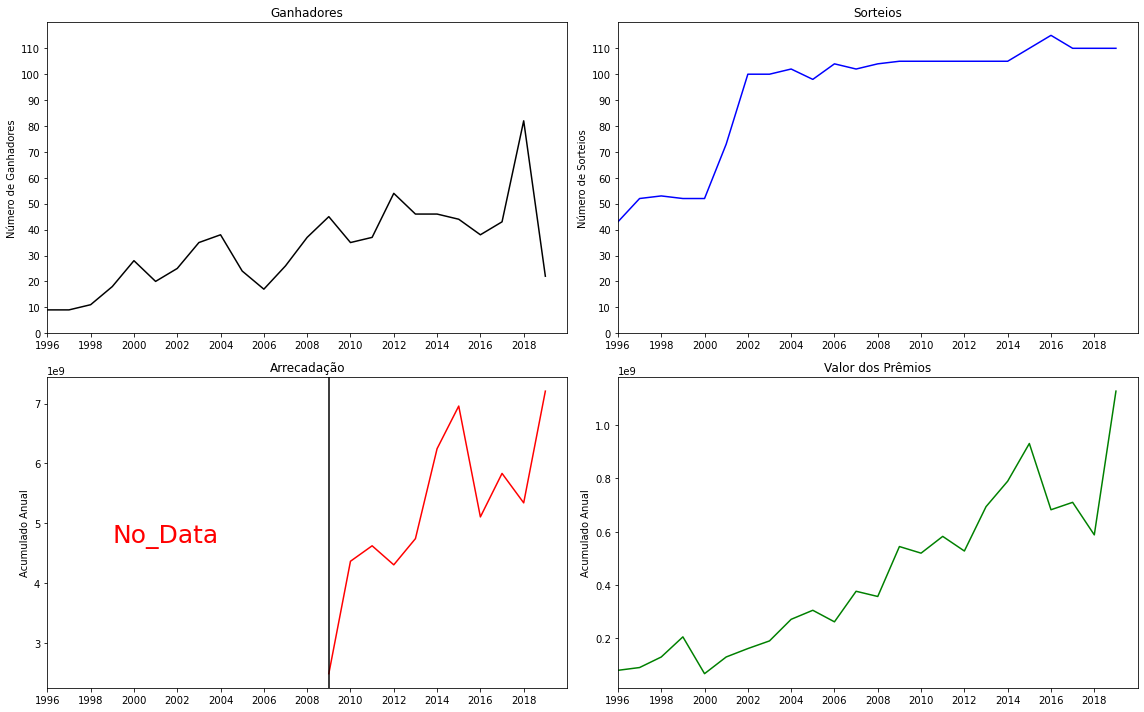

In [9]:
# Gráficos 
ano = mega_sena.Data.dt.year.max() - 1
ano_str = str(ano)

x_lim = ano + 1

# Definindo o tamanho da figura de plotagem
plt.figure(figsize=(16,10))

# Gráfico 1
plt.subplot(221)
plt.plot(ganhadores_ano.loc[:ano_str], color='black')
plt.ylim(0, sorteios_ano.max() + 5)
plt.yticks(range(0, sorteios_ano.max(), 10))
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Ganhadores')
plt.ylabel('Número de Ganhadores')

# Gráfico 2
plt.subplot(222)
plt.plot(sorteios_ano.loc[:ano_str], color='blue')
plt.ylim(0, sorteios_ano.max() + 5)
plt.yticks(range(0, sorteios_ano.max(), 10))
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Sorteios')
plt.ylabel('Número de Sorteios')

# Gráfico 3
plt.subplot(223)
plt.plot(arrec_ano.loc['2009':ano_str], color='red')
plt.axvline(2009, 0, arrec_ano.max(), color='black')
plt.text(1999, arrec_ano.max() * 0.65, 'No_Data', size=25, color='red')
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Arrecadação')
plt.ylabel('Acumulado Anual')

# Gráfico 4
plt.subplot(224)
plt.plot(premios_ano.loc[:ano_str], color='green')
plt.xlim(1996, x_lim)
plt.xticks(range(1996, ano+1, 2))
plt.title('Valor dos Prêmios')
plt.ylabel('Acumulado Anual')

plt.tight_layout()
plt.show()

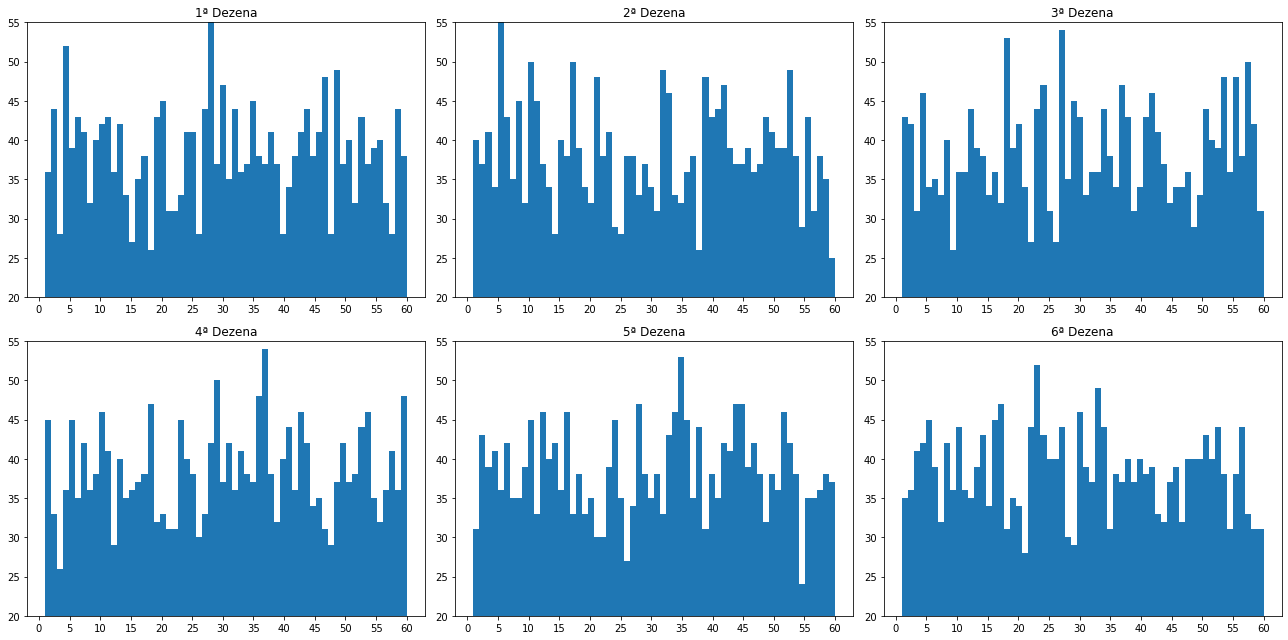

In [10]:
# Avaliando a distribuição de frêquencia entre os números sorteados em cada dezena
mega_dezenas = mega_sena.loc[:, '1_n':'6_n']

plt.figure(figsize=(18,9))

for i, n in enumerate(mega_dezenas.columns):
    plt.subplot(231+i)
    plt.hist(mega_dezenas[n], bins=60)
    plt.xticks(range(0, 61, 5))
    plt.yticks(range(20, 56, 5))
    plt.ylim(20, 55)
    plt.title(f'{i+1}ª Dezena')

plt.tight_layout()

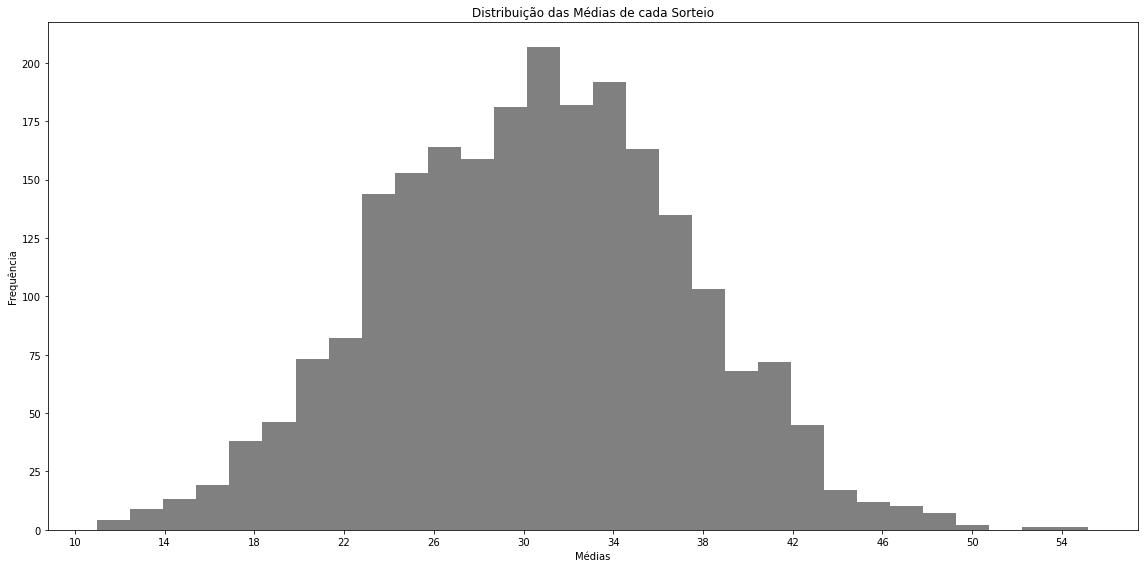

In [11]:
# Avaliando a distribuição das médias entre os 6 números sorteados em cada sorteio.

plt.figure(figsize=(16,8))
plt.hist(mega_dezenas.agg(func=['mean'], axis=1)['mean'], bins=30, color='gray')
plt.xticks(range(10, 58, 4))
plt.title('Distribuição das Médias de cada Sorteio')
plt.xlabel('Médias')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

In [12]:
# Preparando o dataset para avaliação geral dos números
dezenas = mega_dezenas.reset_index(level=0)

dezenas = dezenas.melt(id_vars='Concurso',
                       value_vars=['1_n', '2_n', '3_n', '4_n', '5_n', '6_n'],
                       var_name='Dezena',
                       value_name='Numero')

dezenas.sort_values(['Concurso', 'Dezena']).reset_index(drop=True).head(12)

,Concurso,Dezena,Numero
0,1,1_n,41
1,1,2_n,5
2,1,3_n,4
3,1,4_n,52
4,1,5_n,30
5,1,6_n,33
6,2,1_n,9
7,2,2_n,39
8,2,3_n,37
9,2,4_n,49


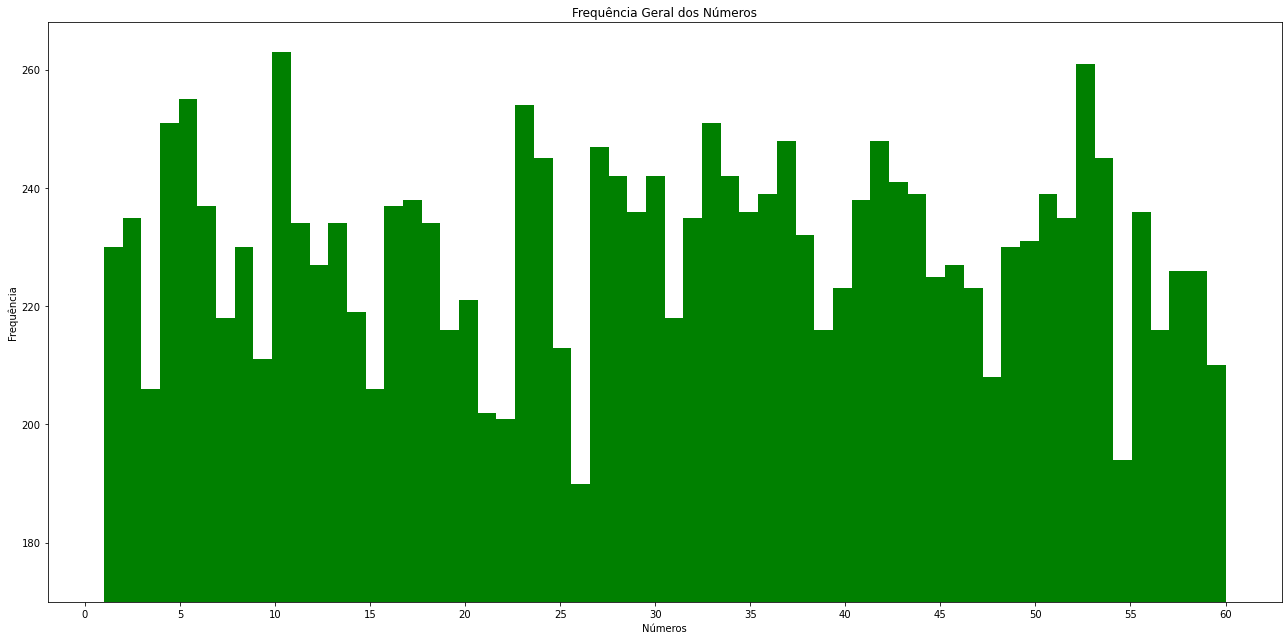

In [13]:
# Avaliando a distribuição de frequência geral dos números, descartando a dezena em que foi sorteado.
y_lim = dezenas.Numero.value_counts().max() + 5

plt.figure(figsize=(18,9))
plt.hist(dezenas['Numero'], bins=60, color='green')
plt.xticks(range(0, 61, 5))
plt.ylim(170, y_lim)
plt.title('Frequência Geral dos Números')
plt.xlabel('Números')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

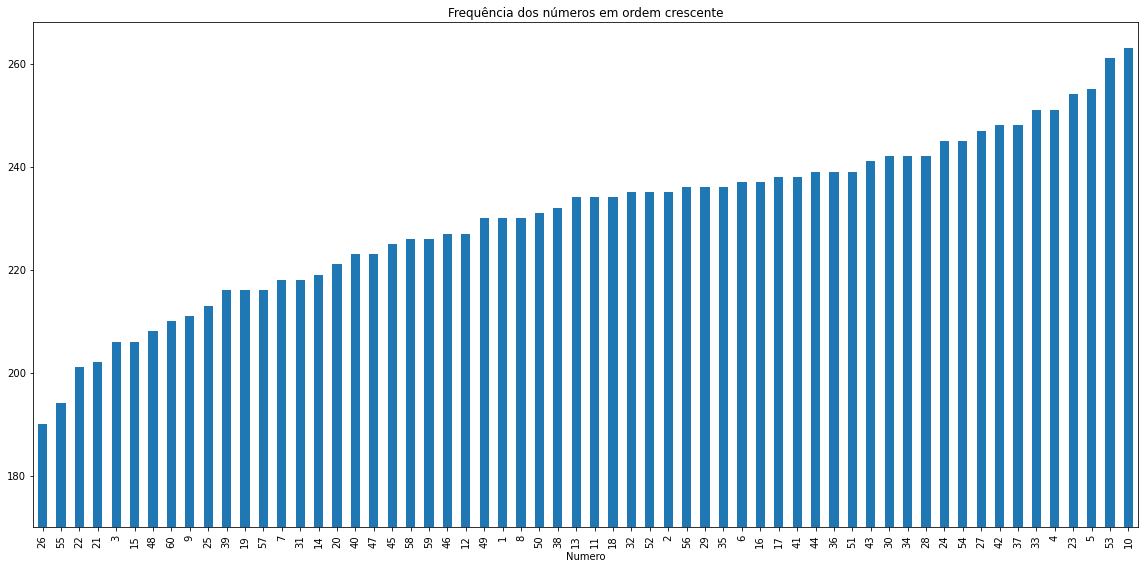

In [14]:
# Organizando o gráfico em ordem crescente de frequência

freq = dezenas.groupby('Numero').count().iloc[:,0]

plt.figure(figsize=(16,8))
freq.sort_values().plot(kind='bar')
plt.title('Frequência dos números em ordem crescente')
plt.ylim(170, y_lim)
plt.tight_layout()
plt.show()

In [15]:
print_frequency_report(frequency_dataframe=freq)

OS NÚMEROS QUE MAIS APARECERAM FORAM:

10 que apareceu em 263 sorteios
53 que apareceu em 261 sorteios
5 que apareceu em 255 sorteios
23 que apareceu em 254 sorteios
4 que apareceu em 251 sorteios
33 que apareceu em 251 sorteios

OS NÚMEROS QUE MENOS APARECERAM FORAM:

26 que apareceu em 190 sorteios
55 que apareceu em 194 sorteios
22 que apareceu em 201 sorteios
21 que apareceu em 202 sorteios
3 que apareceu em 206 sorteios
15 que apareceu em 206 sorteios

Jogo com números mais frequentes: [4, 5, 10, 23, 33, 53]
Jogo com números menos frequentes: [3, 15, 21, 22, 26, 55]


## Testes Estatíscos:

**Vamos validar a tabela de probabilidades da Caixa Econômica Federal?**

In [16]:
# Importando os pacotes
from statistics.gambler import Gambler
from statistics.club import GamblersClub

In [17]:
intervalo_numeros = 60              #Intevalo de números aleatórios(Ex: MegaSena = 60)
quantidade_numeros_sorteados = 6    #Quantidade de números a serem sorteados (Ex: MegaSena = 6)
quantidade_numeros_jogados = 6      #Quantidade de números escolhidos para jogar (Ex: MegaSena de 6 até 15)
jogos_por_jogador = 1_000_000       #Quantidade de jogos aleatórios para tentar acertar o sorteio
jogadores = 10                      #Quantidade de repetições para gerar um amostra estatística 

In [18]:
gamblers = GamblersClub(numbers_range=intervalo_numeros,
                        numbers_amount=quantidade_numeros_sorteados,
                        numbers_played=quantidade_numeros_jogados,
                        trials=jogos_por_jogador,
                        players=jogadores)

In [19]:
gamblers.raffle_numbers

[1, 47, 33, 50, 31, 39]

In [20]:
%time gamblers.play()

Wall time: 1min 14s


In [21]:
jogos_por_jogador = 1           

In [22]:
gambler = Gambler(numbers_range=intervalo_numeros,
                  numbers_amount=quantidade_numeros_sorteados,
                  numbers_played=quantidade_numeros_jogados,
                  trials=jogos_por_jogador)

In [23]:
gambler.raffle_numbers

[40, 26, 56, 37, 36, 14]

In [24]:
gambler.gamble()

[[1, 27, 54, 33, 50, 20]]

In [25]:
gambler.check_hits()

[0]

In [26]:
gambler.play()


That´s SAD! We tried 1 time(s), but, we didn't hit all the 6 numbers!
Our best game just hit 1 number(s)!


In [27]:
from magazine.reporter import Reporter

In [28]:
reporter = Reporter(gambler_hits=gamblers.hits_list,
                    numbers_played=gamblers.numbers_played)

In [29]:
reporter.show_probabilities_dataframe()

   Numeros    Valor         6       5     4
0        6      4,5  50063860  154518  2332
1        7     31,5   7151980   44981  1038
2        8      126   1787995   17192   539
3        9      378    595998    7791   312
4       10      945    238399    3973   195
5       11     2079    108363    2211   129
6       12     4158     54182    1317    90
7       13     7722     29175     828    65
8       14  13513,5     16671     544    48
9       15  22522,5     10003     370    37


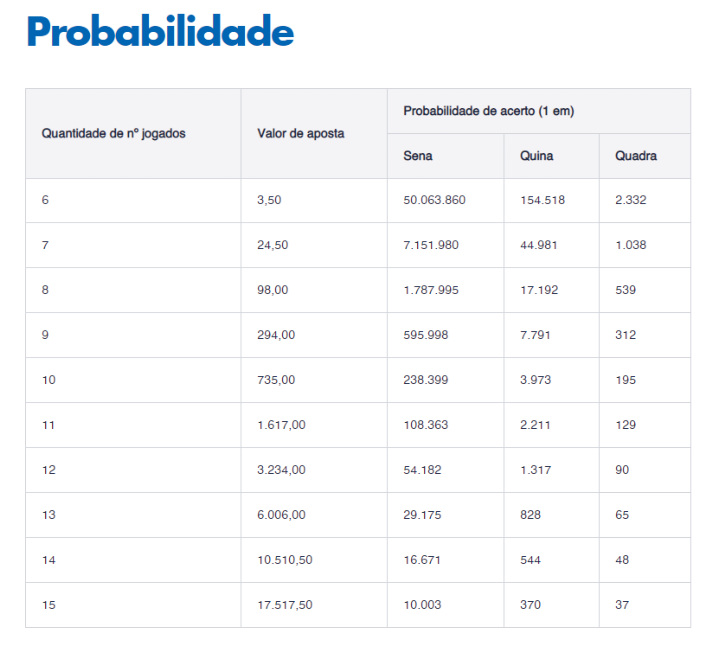

In [30]:
reporter.show_probabilities_image()

In [31]:
reporter.hit_report(number=4)

The mean score was approximately 422 each 1,000,000 trials:

1 hit each 2,369 games played!
We have played with 6 numbers.

the raffler says: 2,332
What do you think?


In [32]:
reporter.confidence_report(number=4, confidence=0.95)

A média da quantidade de acertos foi de 409 até 436 considerando 95% de confiança


In [33]:
reporter.save_hits()

In [34]:
reporter2 = Reporter()

In [36]:
reporter2.load_hits(f'data/trials-1_000_000-samples-10-numbers-6.npy')

In [37]:
reporter2.numbers_played

6

In [38]:
reporter2.hit_report(number=5)

The mean score was approximately 7 each 1,000,000 trials:

1 hit each 142,857 games played!
We have played with 6 numbers.

the raffler says: 154,518
What do you think?


# FIM!